<a href="https://colab.research.google.com/github/BelenFranzoni/mentoria-diplodatos-2024-analisis-cursos-previsionales/blob/main/Entrega_2_Mentor%C3%ADa_15_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Cursos Previsionales

**Grupo M15**

Pedro Fenoglio

Belén Franzoni

Lautaro Gomez Dunaevsky

**En este proyecto de mentoría se analizará una serie de datos reales correspondientes a la venta de cursos educativos del área previsional.
Trabajaremos sobre los datos anonimizados de compras de una plataforma de cursos onlines. Exploraremos las distintas fuentes de datos y haremos un análisis descriptivo y visual de los datos para entender cómo están distribuidas las ventas. ***

El dataset está constituido por tres bases: clientes, ventas y contactos.
Para esta segunda entrega de la mentoría trabajaremos solamente con la base de contactos, que es en la base en la que se encuentran las consultas de los clientes.

En la tercera parte de la mentoría se combinará esta data con la de orders para ver si es posible relacionar las consultas con el estado final (venta realizada o no) de las órdenes.




# Detección de tópicos de consulta
En esta entrega, realizaremos la exploración y preparación de los datasets para detectar los tópicos de las consultas realizadas. El trabajo se dividirá principalmente en dos secciones:



1.   Para lograr este objetivo arrancaremos con una exporación inicial de los datasets que utilizaremos, detectaremos columnas relevantes, datos faltantes y determinaremos si es necesario realizar input o agregar información desde otras fuentes.
2.   Por otro lado, se aplicarán técnicas de procesamiento de lenguaje natural con el propósito de preparar el conjunto de datos para entrenar un modelo predictivo.
3.   Por último, se realizará la vectorización de los mensajes a través de las técnicas de Bag of Words  y TF-IDF.





### Librerias a utilizar

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('punkt')
nltk.download('stopwords')
!python -m spacy download es_core_news_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 45.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Datasets a utilizar

In [ ]:
contacts_url = "https://raw.githubusercontent.com/adrian-alejandro/mentoria-diplodatos-2024-analisis-cursos-previsionales/main/datos/contacts_anon.csv"
contacts = pd.read_csv(contacts_url, encoding='latin1')

In [ ]:
print(contacts.shape)

(1790, 7)


In [ ]:
contacts.head()

,id,fecha,nombre,email,genero,asunto,mensaje
0,80242452935422199706,16/03/2024 14:55:28,Dani Castellanos Briones,dani.castellanos.briones2358@hotmail.com,M,Consulta general,. quisiera saber si existe algun simulador del...
1,15409661513166318845,13/03/2024 16:13:09,Apolinar Jimenez Teruel,apolinar.jimenez.teruel6338@gmail.com,M,Consulta general,no puedo ver los videos del curso. necesito ayuda
2,67687345747217393942,12/03/2024 18:47:42,Evangelina Clotilde Requena Sans,evangelina.clotilde.requena.sans5853@gmail.com,F,Consulta general,"hola, me surge una duda de la ley . mujer de a..."
3,70437236079243373753,19/09/2023 10:56:11,Evangelina Clotilde Requena Sans,evangelina.clotilde.requena.sans5853@gmail.com,F,Consulta general,estoy interesada en el curso. como pago? gracias
4,65048242968545317160,18/05/2023 17:29:08,Evangelina Clotilde Requena Sans,evangelina.clotilde.requena.sans5853@gmail.com,F,Consulta general,"hola, las clases ya estan gravadas? si pago te..."


In [ ]:
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1790 non-null   object
 1   fecha    1790 non-null   object
 2   nombre   1790 non-null   object
 3   email    1790 non-null   object
 4   genero   1790 non-null   object
 5   asunto   1790 non-null   object
 6   mensaje  1788 non-null   object
dtypes: object(7)
memory usage: 98.0+ KB


In [ ]:
# @title Nombres: De las 1790 entradas veamos cuántos nombres no repetidos encontramos.
print("nombres de contactos", len(contacts.nombre.unique()))


nombres de contactos 1377


Text(0, 0.5, 'Género')

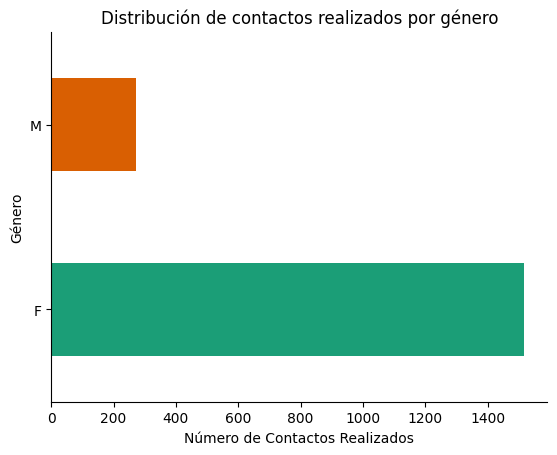

In [ ]:
# @title Género: Vemos que información nos da esta columna. Cómo se distribuyen las consultas

contacts.groupby('genero').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Distribución de contactos realizados por género')
plt.xlabel('Número de Contactos Realizados')
plt.ylabel('Género')

In [ ]:
# @title Email: De las 1790 entradas veamos cuántos email no repetidos encontramos.
print("email de contactos", len(contacts.email.unique()))

email de contactos 1584


Algo llamativo es que hay más emails que no se repiten que nombres de contactos, esto puede deberse a que algunas personas realizan consultas usando diferentes emails o que la anonimazación no es 1 a 1.

In [ ]:
# @title Asunto: Veamos de la variable asuntos cuántos tipos de consultas se realizan

num_entradas_diferentes = contacts['asunto'].nunique()

print(f'Número de entradas diferentes en la columna asuntos: {num_entradas_diferentes}')
entradas_diferentes = contacts['asunto'].unique()
for entrada in entradas_diferentes:
    print(entrada)

Número de entradas diferentes en la columna asuntos: 19
Consulta general
Consulta de precio de PACK x 3 - Curso 12 + Curso 17 + Curso 19
Consulta de precio de - Curso 2
Consulta de precio de PACK x 2 - Curso 4 + Curso 17
Consulta de precio de - Curso 1
Consulta de precio de PACK X 7 - Curso 7
Consulta de precio de PACK X 5 - Curso 7
Consulta de precio de PACK X 6 - Curso 7
Consulta de precio de PACK x 3 - Curso 9
Consulta de precio de - Curso 10
Consulta de precio de - Curso 6
Consulta de precio de PACK x 3 - Curso 12 + Curso 17 + Curso 13
Consulta de precio de - Curso 3
Consulta de precio de - Curso 22
Consulta de precio de - Curso 20
Consulta de precio de PACK x 3 - Curso 23
Consulta de precio de - Curso 16
Consulta de precio de - Curso 24
Consulta de precio de - Curso 5


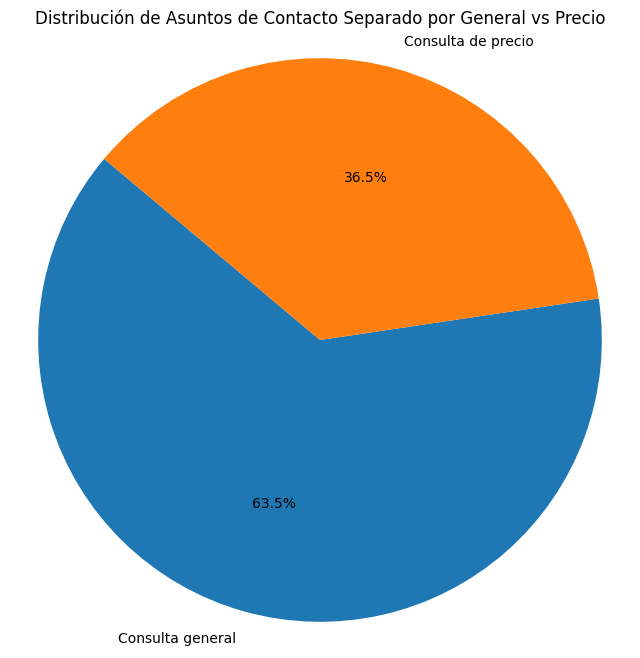

In [ ]:
consulta_general_count = contacts['asunto'].str.contains("Consulta general").sum()

# Contar las ocurrencias de "Consulta de precio"
consulta_precio_count = contacts['asunto'].str.contains("Consulta de precio").sum()
# Contar las ocurrencias de "Consulta de precio" que incluyen "Curso 2"
consulta_precio_curso2_count = contacts['asunto'].str.contains("Consulta de precio").sum() & contacts['asunto'].str.contains("Curso 2").sum()

# Calcular las ocurrencias de "Consulta de precio" que no incluyen "Curso 2"
consulta_precio_no_curso2_count = consulta_precio_count - consulta_precio_curso2_count

# Datos para el gráfico
#labels = ['Consulta general', 'Consulta de precio con Curso 2', 'Consulta de precio sin Curso 2']
#sizes = [consulta_general_count, consulta_precio_curso2_count, consulta_precio_no_curso2_count]

# Datos para el gráfico
labels = ['Consulta general', 'Consulta de precio']
sizes = [consulta_general_count, consulta_precio_count]

# Crear gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Igualar ejes para que sea un círculo

# Mostrar gráfico
plt.title('Distribución de Asuntos de Contacto Separado por General vs Precio')
plt.show()

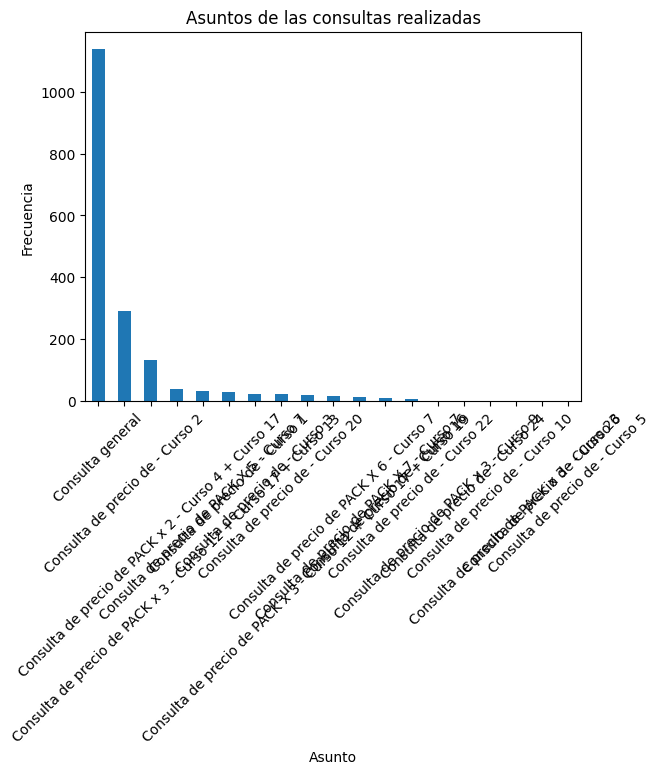

In [ ]:
# @title Asunto: Veamos cómo se distribuyen las consultas que se realizan
contacts['asunto'].value_counts().plot(kind='bar')

plt.title('Asuntos de las consultas realizadas')
plt.xlabel('Asunto')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.show()

In [ ]:
contacts['asunto'].groupby(contacts['asunto']).value_counts()

,,count
asunto,asunto,
Consulta de precio de - Curso 1,Consulta de precio de - Curso 1,29
Consulta de precio de - Curso 10,Consulta de precio de - Curso 10,1
Consulta de precio de - Curso 16,Consulta de precio de - Curso 16,10
Consulta de precio de - Curso 2,Consulta de precio de - Curso 2,292
Consulta de precio de - Curso 20,Consulta de precio de - Curso 20,23
Consulta de precio de - Curso 22,Consulta de precio de - Curso 22,7
Consulta de precio de - Curso 24,Consulta de precio de - Curso 24,1
Consulta de precio de - Curso 3,Consulta de precio de - Curso 3,25
Consulta de precio de - Curso 5,Consulta de precio de - Curso 5,1


In [ ]:
# @title Valores Faltantes
valores_faltantes = contacts.isnull().sum()

# Filtrar las columnas que tienen al menos un valor faltante
columnas_con_faltantes = valores_faltantes[valores_faltantes > 0]

print(columnas_con_faltantes)

mensaje    2
dtype: int64


In [ ]:
# Como son sólo dos filas con mensaje faltante, y el análisis lo queremos hacer sobre ese campo, removemos esas dos filas
contacts.dropna(inplace=True)
print(contacts.shape)

(1788, 7)


Se removieron dos filas de contacts

# **Descripción de las variables del data set**

Contamos con un total de 7 variables categóricas con 1790 entradas.

Las mismas se definen de la siguiente manera

- id: Es algún número identificador del cliente.

- fecha: Se refiere al momento en el que se realizó la consulta.

- Nombre: Es un nombre anonimizado de quien realizó la consulta. Hay 1377 nombres diferentes en las 1790 entradas. No se presenta en este análisis pero se observó que hay 278 nombres que coinciden entre esta base y la de orders.

- Género : Se refiere al sexo biológico de la persona. Está definida como una variable binaria (F o M). Aproximadamente el 85% de las consultas corresponden a género F.

- Email: Es un mail anonimizado de quien realizó la consulta. Hay 1584 nombres diferentes en las 1790 entradas.

- Asunto: Hace referencia al tipo de consulta que se realiza. Hay 19 tipos de consultas diferentes. Consulta general y 18 consultas sobre precios de los diferentes productos. Consulta general es la más frecuente. Dentro de las consultas de cursos en particular sólo aparecen un número relevante de veces aquellas que incluyen el curso 2.

- Mensaje: En la consulta, el texto que se va a preparar para el modelo predictivo. Esta variable es la única que tiene 2 valores no nulos. Se decidió remover estos dos datos faltantes.




***En esta parte nos centraremos en el preparado de la columna mensaje. Quizás luego se pueda filtrar además por el tipo de consulta realizada.***

## 2.Procesamiento de lenguaje natural



Se utilizará alguna librería de procesamiento de lenguaje natural (e.g. NLTK, SpaCy) para realizar la tokenización, la eliminación de puntuación, la remoción de las stopwords, stemming y lematicación (sobre estos dos últimos, a pesar de aplicar ambos métodos por fines didácticos, se elegirá solo uno para continuar con la vectorización).

Sobre cada técnica utilizadas, se realizará una breve descripción de su fin y utilidad.

### Tokenización

La tokenización se refiere al proceso de dividir un texto en unidades más pequeñas llamadas tokens. Estos tokens pueden ser palabras individuales o también pueden ser un conjunto de palabras, números, signos de puntuación, o cualquier otra unidad significativa dependiendo del contexto y del objetivo del análisis. Para nuestro caso tomaremos como token palabras individuales y descartaremos los conjuntos.

In [ ]:
# Se convierte el campo de mensaje a tipo string
contacts['mensaje'] = contacts['mensaje'].astype(str)

# Se aplica el método de tokenización word_tokenize
contacts['mensaje_tokenizado'] = contacts['mensaje'].apply(word_tokenize)

### Eliminación de puntuación

Esta técnica consiste en eliminar el ruido que existe en cada mensaje producto de la puntuación. Se elimnan comas, guiones, puntos, comillas, doble puntos, entre otros caracteres.

In [ ]:
# Función para eliminar signos de puntuación
def remove_punctuation(tokens):
    # Lista de signos de puntuación
    punctuations = string.punctuation
    # Filtrar tokens que no sean signos de puntuación
    return [token for token in tokens if token not in punctuations]

# Aplicar la función a la columna 'mensaje_tokenizado'
contacts['mensaje_tokenizado'] = contacts['mensaje_tokenizado'].apply(remove_punctuation)

In [ ]:
print(contacts['mensaje_tokenizado'].head())

0    [quisiera, saber, si, existe, algun, simulador...
1    [no, puedo, ver, los, videos, del, curso, nece...
2    [hola, me, surge, una, duda, de, la, ley, muje...
3    [estoy, interesada, en, el, curso, como, pago,...
4    [hola, las, clases, ya, estan, gravadas, si, p...
Name: mensaje_tokenizado, dtype: object


### Remoción de stopwords

Las stopwords son palabras vacías que no aportan mucho significado al texto. Se utiliza esta técnica para filtrarlas y eliminar el ruido dentro de los mensajes utilizados

In [ ]:
# Configuramos la libreria stopwords en español
stop_words = set(stopwords.words('spanish'))

# Función para eliminar stopwords
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Aplicar la función para eliminar stopwords
contacts['mensaje_filtrado'] = contacts['mensaje_tokenizado'].apply(remove_stopwords)

In [ ]:
print(contacts['mensaje_filtrado'].head())

0    [quisiera, saber, si, existe, algun, simulador...
1         [puedo, ver, videos, curso, necesito, ayuda]
2    [hola, surge, duda, ley, mujer, anos, siete, m...
3                   [interesada, curso, pago, gracias]
4    [hola, clases, estan, gravadas, si, pago, acce...
Name: mensaje_filtrado, dtype: object


### Stemming

Stemming es una técnica de normalización de texto en el procesamiento del lenguaje natural que reduce las palabras a su raíz. La técnica de stemming elimina los afijos de las palabras, lo que puede generar palabras no válidas.

In [ ]:
# Definir la función para aplicar stemming a una lista de palabras
def stem_words(word_list, stemmer):
    return [stemmer.stem(word) for word in word_list]

# Crear el stemmer para español
stemmer = SnowballStemmer('spanish')

# Aplicar el stemming a la columna del DataFrame
contacts['mensaje_stemmed'] = contacts['mensaje_filtrado'].apply(lambda x: stem_words(x, stemmer))

In [ ]:
print(contacts['mensaje_stemmed'].head())

0    [quis, sab, si, exist, algun, simul, hab, jubi...
1               [pued, ver, vide, curs, necesit, ayud]
2    [hol, surg, dud, ley, muj, anos, siet, mes, pu...
3                          [interes, curs, pag, graci]
4    [hol, clas, estan, grav, si, pag, acces, inmed...
Name: mensaje_stemmed, dtype: object


### Lematización
La lematización es el proceso de reducir las palabras a su forma base o "lema". Esto significa convertir las palabras a su forma de diccionario. Por ejemplo, las palabras "corriendo" y "corrió" se reducen a su lema "correr".

In [ ]:
# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Función para lematizar una lista de palabras
def lematizar_lista(lista):
    doc = nlp(" ".join(lista))
    return [token.lemma_ for token in doc]

# Aplicar la lematización a la columna 'text'
contacts['mensaje_lematizado'] = contacts['mensaje_filtrado'].apply(lematizar_lista)


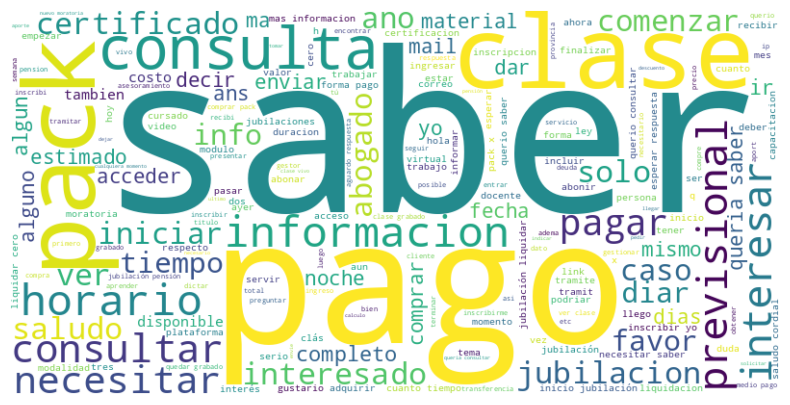

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Concatenar todos los tokens en una sola lista
all_tokens = sum(contacts['mensaje_lematizado'], [])

# Convertir la lista en una sola cadena de texto
text = ' '.join(all_tokens)

# Palabras a excluir
exclusion_list = {'buen', 'dia', 'gracia', 'mucho', 'gracias', 'holar', 'buena', 'tarde','poder','curso','si', 'hacer','querer', 'él', 'realizar'}

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=STOPWORDS.union(exclusion_list)).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar ejes
plt.show()

In [ ]:
print(contacts['mensaje_lematizado'].head())

0    [querer, saber, si, existir, algun, simulador,...
1         [poder, ver, video, curso, necesitar, ayuda]
2    [holar, surgir, dudo, ley, mujer, ano, siete, ...
3                   [interesado, curso, pago, gracias]
4    [holar, clase, estar, gravada, si, pagar, acce...
Name: mensaje_lematizado, dtype: object


In [ ]:
from collections import Counter

# Combinar todas las listas de palabras en una sola lista
all_words = [word for mensaje in contacts['mensaje_lematizado'] for word in mensaje]

# Utilizar Counter para encontrar las palabras más comunes
most_common_words = Counter(all_words).most_common(20)

print(most_common_words)



[('curso', 1327), ('si', 531), ('poder', 526), ('querer', 394), ('saber', 381), ('gracia', 353), ('buena', 353), ('hacer', 338), ('buen', 308), ('tarde', 286), ('dia', 267), ('gracias', 263), ('mucho', 221), ('pago', 213), ('clase', 201), ('holar', 186), ('realizar', 184), ('informacion', 167), ('pack', 165), ('jubilación', 144)]


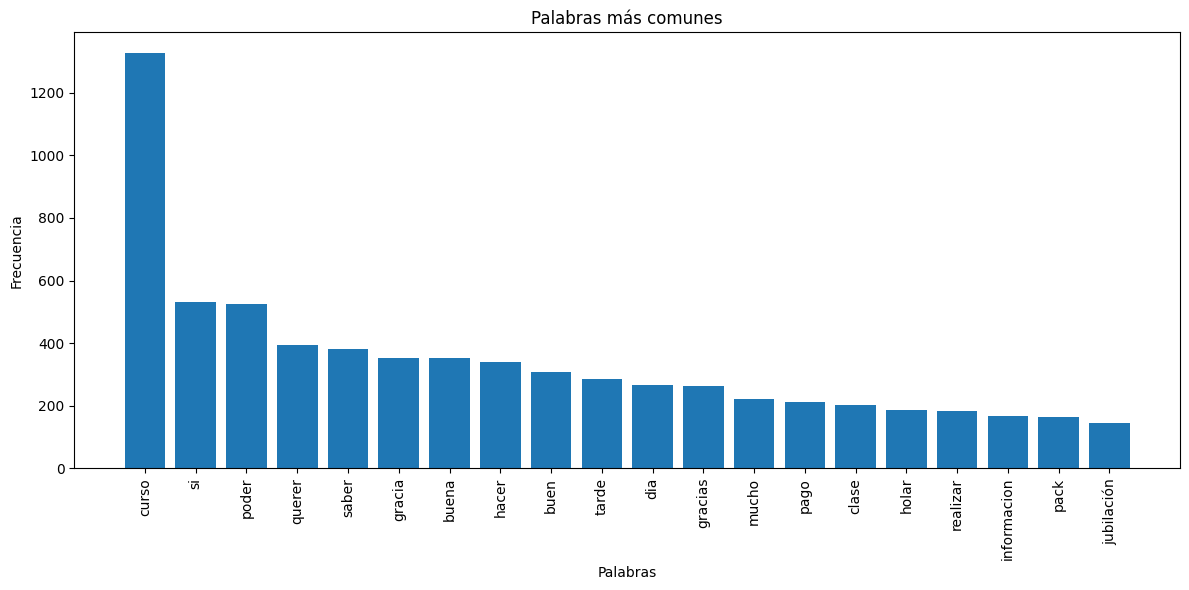

In [ ]:
# Extraer palabras y frecuencias para el histograma
words = [word for word, count in most_common_words]
counts = [count for word, count in most_common_words]

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más comunes')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para legibilidad
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

In [ ]:
from collections import Counter
from nltk.util import ngrams

n_gram = 2

# Generar n-gramas
n_grams_list = list(ngrams(all_words, n_gram))

# Contar la frecuencia de los n-gramas
n_gram_dic = dict(Counter(n_grams_list))
# Filtrar y ordenar los n-gramas por frecuencia en orden descendente
sorted_n_grams = sorted(n_gram_dic.items(), key=lambda item: item[1], reverse=True)

# Mostrar n-gramas que aparecen al menos 2 veces
for n_gram, count in sorted_n_grams:
    if count >= 4:
        print(n_gram, count)

('buena', 'tarde') 277
('mucho', 'gracia') 211
('saber', 'si') 205
('buen', 'dia') 198
('querer', 'saber') 167
('hacer', 'curso') 91
('si', 'poder') 69
('gracia', 'buena') 65
('curso', 'inicio') 65
('buen', 'dias') 59
('interesar', 'curso') 55
('curso', 'poder') 49
('si', 'curso') 49
('queria', 'saber') 49
('inicio', 'jubilación') 47
('buena', 'noche') 47
('gracias', 'buena') 46
('realizar', 'curso') 46
('pack', 'curso') 45
('poder', 'hacer') 45
('consultar', 'si') 45
('tarde', 'querer') 45
('informacion', 'curso') 43
('gracia', 'buen') 41
('gracias', 'buen') 38
('holar', 'buen') 37
('buen', 'diar') 36
('poder', 'ver') 35
('cuanto', 'tiempo') 34
('si', 'clase') 34
('curso', 'previsional') 34
('interesado', 'curso') 33
('necesitar', 'saber') 32
('gracia', 'querer') 31
('curso', 'jubilación') 31
('querer', 'hacer') 31
('jubilación', 'liquidar') 31
('querio', 'consultar') 31
('poder', 'realizar') 31
('curso', 'completo') 30
('curso', 'buena') 30
('mas', 'informacion') 30
('querio', 'saber

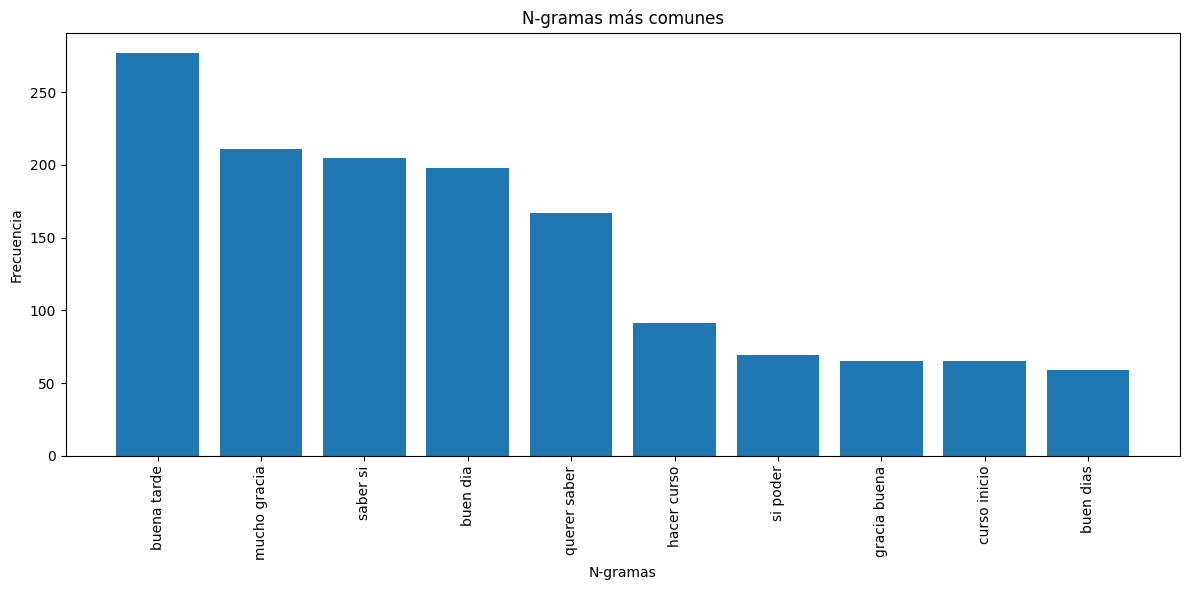

In [ ]:
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt

n_gram = 2

# Generar n-gramas
n_grams_list = list(ngrams(all_words, n_gram))

# Contar la frecuencia de los n-gramas
n_gram_dic = dict(Counter(n_grams_list))

# Filtrar y ordenar los n-gramas por frecuencia en orden descendente, tomando los 10 más comunes
sorted_n_grams = sorted(n_gram_dic.items(), key=lambda item: item[1], reverse=True)[:10]

# Extraer n-gramas y frecuencias para el gráfico
n_grams = [' '.join(n_gram) for n_gram, count in sorted_n_grams]
counts = [count for n_gram, count in sorted_n_grams]

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(n_grams, counts)
plt.xlabel('N-gramas')
plt.ylabel('Frecuencia')
plt.title('N-gramas más comunes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

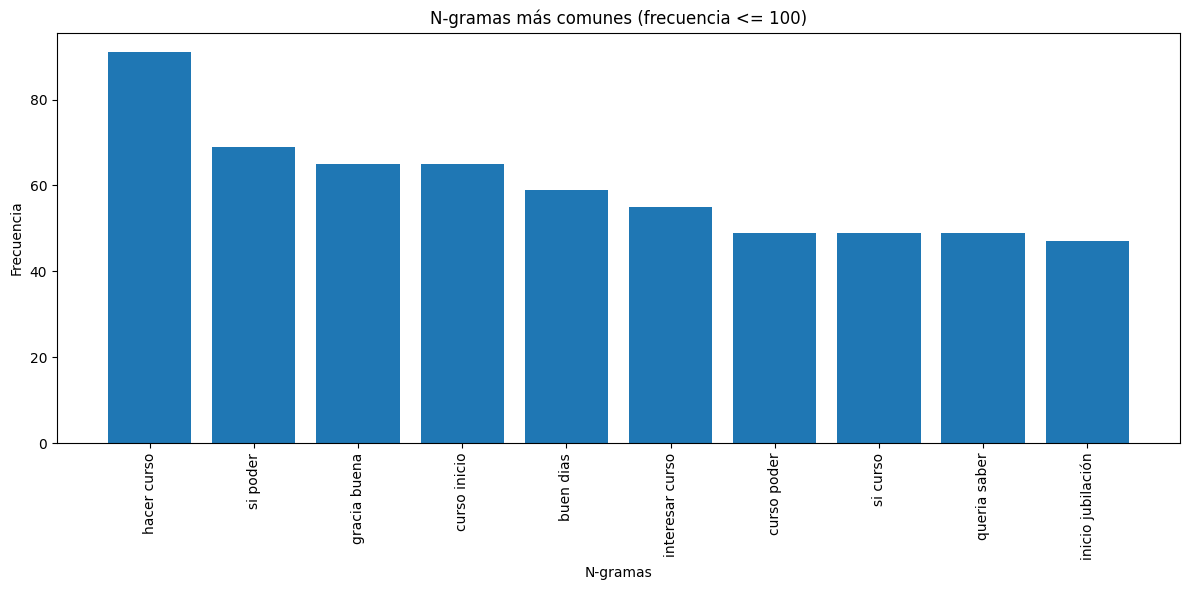

In [ ]:
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt

n_gram = 2

# Generar n-gramas
n_grams_list = list(ngrams(all_words, n_gram))

# Contar la frecuencia de los n-gramas
n_gram_dic = dict(Counter(n_grams_list))

# Filtrar n-gramas con frecuencia menor o igual a 100
filtered_n_grams = {k: v for k, v in n_gram_dic.items() if v <= 100}

# Ordenar los n-gramas filtrados por frecuencia en orden descendente, tomando los 10 más comunes
sorted_n_grams = sorted(filtered_n_grams.items(), key=lambda item: item[1], reverse=True)[:10]

# Extraer n-gramas y frecuencias para el gráfico
n_grams = [' '.join(n_gram) for n_gram, count in sorted_n_grams]
counts = [count for n_gram, count in sorted_n_grams]

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(n_grams, counts)
plt.xlabel('N-gramas')
plt.ylabel('Frecuencia')
plt.title('N-gramas más comunes (frecuencia <= 100)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 3. Vectorización

Una forma usual de tratar los datos de textos es mediante alguna representación numérica/vectorial. Para esto utilizaremos la librería scikit-learn. Se aplicarán dos transformaciones sobre el texto preprocesado en el punto 2 y se describirán en simples palabras en qué consiste cada método.

### Bag of Words

El método Bag of Words (BoW) es una técnica utilizada en el procesamiento del lenguaje natural (NLP) para convertir texto en una representación numérica que puede ser utilizada por algoritmos de aprendizaje automático. La idea principal detrás de BoW es tratar el texto como una colección de palabras, ignorando el orden y la gramática, y simplemente contabilizar la frecuencia de aparición de cada palabra en el texto.

In [ ]:
# Unir la lista de texto de cada fila
contacts['lematizado_joined'] = contacts['mensaje_lematizado'].apply(lambda x: ' '.join(x))

# Inicializar el CountVectorizer
vectorizer = CountVectorizer()

# Ajustar el vectorizador al corpus
X = vectorizer.fit_transform(contacts['lematizado_joined'])

# Mostrar el vocabulario aprendido
print(vectorizer.get_feature_names_out())

# Convertir la matriz de conteo en una matriz densa y mostrarla
print(X.toarray())

# Imprimimos las dimensiones de la nueva matriz
print(X.shape)

['aactualizado' 'abanico' 'abarca' ... 'zoom' 'zón' 'él']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1788, 2580)


### Term Frequency - Inverse Document Frequency
TF-IDF (Term Frequency - Inverse Document Frequency) es una técnica utilizada para evaluar la importancia de una palabra en un documento en relación con un corpus de documentos. Combina la frecuencia de término (TF) con la frecuencia inversa de documento (IDF) para penalizar las palabras comunes y dar más peso a las palabras que son más informativas.

In [ ]:
# Inicializar el TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar el vectorizador al texto del DataFrame
X_tfidf = tfidf_vectorizer.fit_transform(contacts['lematizado_joined'])

# Mostrar el vocabulario aprendido
print(tfidf_vectorizer.get_feature_names_out())

# Convertir la matriz TF-IDF en una matriz densa y mostrarla
print(X_tfidf.toarray())

# Imprimir las dimensiones de la nueva matriz
print(X_tfidf.shape)

['aactualizado' 'abanico' 'abarca' ... 'zoom' 'zón' 'él']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1788, 2580)
